In [1]:
def drop_nan(x):
    # https://stackoverflow.com/a/47486199
    return x[~np.isnan(x)]

def get_adiabatic_profile(data):
    p_surf = data['pfull'].values[-1]
    T_s   = data['ta'].values[-1]
    T_min = np.nanmin(data['ta'].values)
    h = np.flip(data['zg'].values)
    p = hydrostratic_profile(h, p_surf)
    p = drop_nan(p)
    h = h[0:len(p)]
    t = get_moist_adiabat(p,  T_s=T_s, T_min=T_min)
    return h,t


def joined_profile(data):
    maxlen = len(drop_nan(cold['pfull'].values))
    h,dry = get_dry_lapse_profile(cold)
    h = h[0:maxlen]
    dry = dry[0:maxlen]
    t = np.flip(data['ta'].values)[0:maxlen]
    p = np.flip(data['pfull'].values)[0:maxlen]
    upper_t = t[h>500]
    upper_p = p[h>500]
    T_s = upper_t[0]
    T_min = np.nanmin(upper_t)
    moist = get_moist_adiabat(upper_p,  T_s=T_s, T_min=T_min)
    tt = np.zeros(maxlen)
    tt[h<=500] = dry[h<=500]
    tt[h>500]  = moist
    return h,tt

def adiabat_fit_plot(ax, data,title):
    h,m = get_adiabatic_profile(cold)
    for lev in h:
        ax.axhline(lev,lw=1,alpha=0.3)
    ax.axhline(500,lw=1,alpha=0.6, color='r',label='500m')
    # ax.scatter(m,h,label='moist')
    ax.plot(m,h,label='moist')
    h,d = get_dry_lapse_profile(cold)
    ax.plot(d,h,label='dry')
    h,t = joined_profile(cold)
    ax.plot(t,h,label='join')
    ax.plot(data['ta'].values,data['zg'].values,label='Monsoon')
    ax.set_xlim(180,310)
    ax.set_ylim(0,23000)
    ax.set_title(title)
    ax.set_xlabel('Temperature / K')
    ax.legend()


In [85]:
# following https://kapernikov.com/ipywidgets-with-matplotlib/
#%matplotlib widget
import ipywidgets as widgets

@widgets.interact(p_0=(0, xmax, 10))
def update(p_0=p_init):
    for ax in [axs[0]]:
        [l.remove() for l in ax.lines] # remove old lines
    plotstuff(axs)
    plt.show()

interactive(children=(IntSlider(value=101045, description='p_0', max=110000, step=10), Output()), _dom_classes…

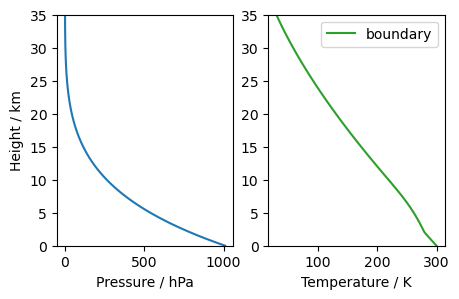

In [98]:
%matplotlib inline


import matplotlib.pyplot as plt

import numpy as np
import metpy.calc as mpcalc
from metpy.units import units

def hydrostatic_profile(h, p_surf):
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.add_height_to_pressure.html
    # This assumes a standard atmosphere [NOAA1976].
    # mpcalc.add_height_to_pressure(pressure, height)
    p = np.zeros(len(h))
    p[0] = p_surf
    for i in range(1,len(p)):
        pressure = p[i-1] * units('Pa')
        height   = (h[i] - h[i-1]) * units('m')
        calc = mpcalc.add_height_to_pressure(pressure, height).to(units('Pa'))
        p[i] = calc.magnitude
        if p[i] == np.nan: p[i] = 0.0
    return p

def dry_lapse_profile(p, T_s=300, T_min=None):
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.dry_lapse.html#metpy.calc.dry_lapse
    # metpy.calc.dry_lapse(pressure, temperature, reference_pressure=None, vertical_dim=0)
    t = mpcalc.dry_lapse(p * units('Pa'),  temperature=T_s * units('K'))
    return t

def moist_lapse_profile(p, T_s=300):
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.moist_lapse.html
    # metpy.calc.moist_lapse(pressure, temperature, reference_pressure=None)
    t = mpcalc.moist_lapse(p * units('Pa'), T_s * units('K'))
    return t

#def boundarylayer(p, T_s=300, surface_saturation=None):
def boundarylayer(p, T_s=300, RH_surf=1.0):
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.parcel_profile.html#metpy.calc.parcel_profile
    # metpy.calc.parcel_profile(pressure, temperature, dewpoint)
    #if not surface_saturation: surface_saturation = mpcalc.saturation_vapor_pressure(T_s * units('K'))
    # dewpoint = mpcalc.dewpoint(surface_saturation)
    dewpoint = mpcalc.dewpoint_from_relative_humidity(T_s * units('K'), RH_surf)
    t = mpcalc.parcel_profile(p * units('Pa'), T_s * units('K'), dewpoint)
    return t

from konrad.lapserate import get_moist_adiabat as konrad_moist_lapse
def konrad_moist_lapse_profile(p, T_s=300.0, T_min=155.0):
    # https://konrad.readthedocs.io/_modules/konrad/lapserate.html#get_moist_adiabat
    # get_moist_adiabat(p, p_s=None, T_s=300.0, T_min=155.0)
    t = konrad_moist_lapse(p,  T_s=T_s, T_min=T_min)
    return t

def plot_pressure(ax, h, p_surf, **kwargs):
    p = hydrostatic_profile(h, p_surf)
    ax.plot(p/100,h/1000, **kwargs)
    ax.set_xlabel('Pressure / hPa')
    ax.set_ylabel('Height / km')

def plot_temperature(ax, h, p_surf, **kwargs):
    p = hydrostatic_profile(h, p_surf)
    #d = dry_lapse_profile(p)
    #m = moist_lapse_profile(p)
    b = boundarylayer(p, RH_surf=0.35)
    #ax.plot(d,h/1000,label='dry', color='tab:blue')
    #ax.plot(m,h/1000,label='moist', color='tab:orange')
    ax.plot(b,h/1000,label='boundary', color='tab:green')
    ax.set_xlabel('Temperature / K')
    ax.legend()
    
p_surf = 101045
xmax=110000
ymax=35000
ylim = [0,ymax]

h = np.linspace(0, ymax, num=100)
fig, axs = plt.subplots(1,2,figsize=(5,3))
plot_pressure(   axs[0], h, p_surf=p_surf, label='MetPy', color='tab:blue')
plot_temperature(axs[1], h, p_surf=p_surf)

focus = [0,5]
for ax in axs:
    ax.set_ylim([0,ymax/1000])
    # ax.set_ylim(focus)
    
plt.show()